In [1]:
import pandas as pd

cases = pd.read_csv('./us.csv')

cases.describe()

,cases,deaths
count,2.230000e+02,223.000000
mean,1.810619e+06,74390.874439
std,1.866601e+06,64300.883472
min,1.000000e+00,0.000000
25%,5.206500e+03,104.000000
50%,1.354284e+06,80748.000000
75%,2.934354e+06,130135.500000
max,6.008376e+06,182986.000000


In [2]:
cases.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


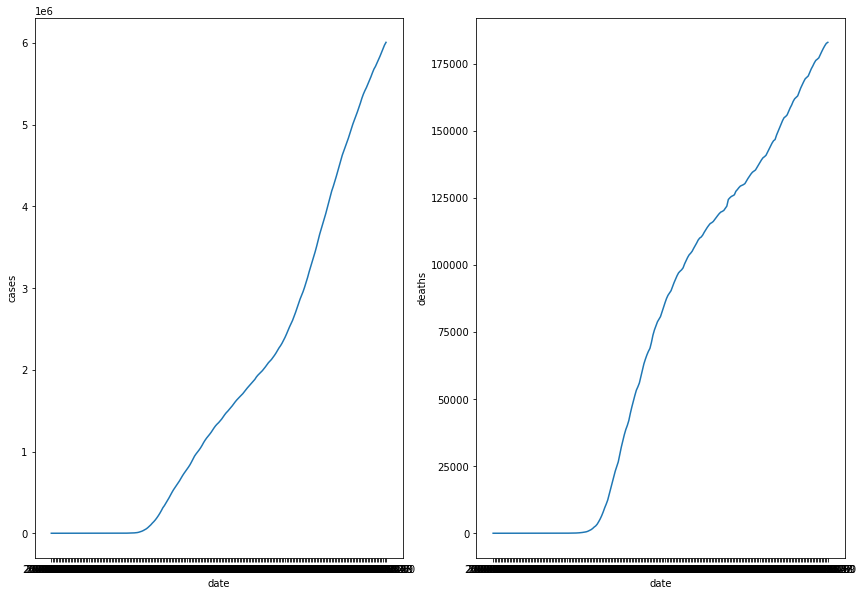

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("husl", 8)

fig, axs = plt.subplots(ncols=0, nrows=2)
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

plt.subplot(1, 2, 1)
sns.lineplot(x="date", y="cases", data=cases)
plt.subplot(1, 2, 2)
sns.lineplot(x="date", y="deaths", data=cases)

plt.show()

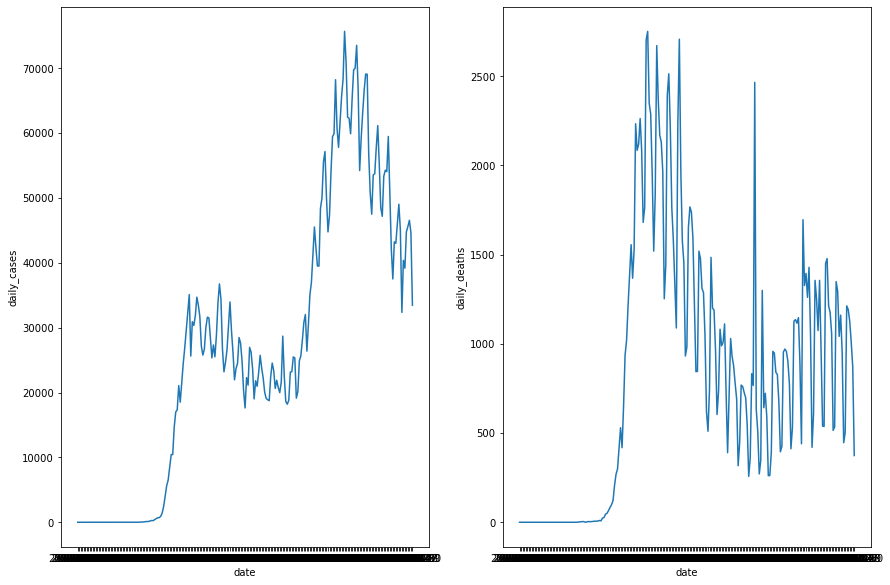

In [4]:
cases['daily_cases'] = [0] + [x - y for x, y in zip(cases['cases'][1:], cases['cases'][:-1])]
cases['daily_deaths'] = [0] + [x - y for x, y in zip(cases['deaths'][1:], cases['deaths'][:-1])]

fig, axs = plt.subplots(ncols=0, nrows=2)
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

plt.subplot(1, 2, 1)
sns.lineplot(x="date", y="daily_cases", data=cases)
plt.subplot(1, 2, 2)
sns.lineplot(x="date", y="daily_deaths", data=cases)

plt.show()

In [5]:
states = pd.read_csv('./us-states.csv')

states.describe()

,fips,cases,deaths
count,9969.000000,9969.000000,9969.000000
mean,31.813923,40502.356706,1664.075133
std,18.588326,83501.973075,4096.909337
min,1.000000,1.000000,0.000000
25%,17.000000,1134.000000,20.000000
50%,31.000000,9513.000000,285.000000
75%,46.000000,43363.000000,1406.000000
max,78.000000,706589.000000,32534.000000


In [6]:
states['daily_cases'] = 0
states['daily_deaths'] = 0

def diff(c):
    dc = [0] + [x - y for x, y in zip(c['cases'][1:], c['cases'][:-1])]
    dd = [0] + [x - y for x, y in zip(c['deaths'][1:], c['deaths'][:-1])]
    ndc = [0] * 7 + dc
    ndd = [0] * 7 + dd
    c['daily_cases'] = dc
    c['daily_deaths'] = dd
    c['seven_day_case'] = [sum(ndc[x:x+7])/7 for x in range(len(ndc) - 7)]
    c['seven_day_death'] = [sum(ndd[x:x+7])/7 for x in range(len(ndd) - 7)]
    c['day'] = list(range(len(c)))
    return c

states = states.groupby('state').apply(diff)

states[states.state == 'California'].tail()

,date,state,fips,cases,deaths,daily_cases,daily_deaths,seven_day_case,seven_day_death,day
9698,2020-08-26,California,6,687612,12547,5292,138,5974.428571,126.571429,214
9753,2020-08-27,California,6,692962,12696,5350,149,5838.571429,123.000000,215
9808,2020-08-28,California,6,698389,12836,5427,140,5651.571429,127.857143,216
9863,2020-08-29,California,6,702499,12906,4110,70,5485.428571,121.714286,217
9918,2020-08-30,California,6,706589,12939,4090,33,5310.571429,109.857143,218


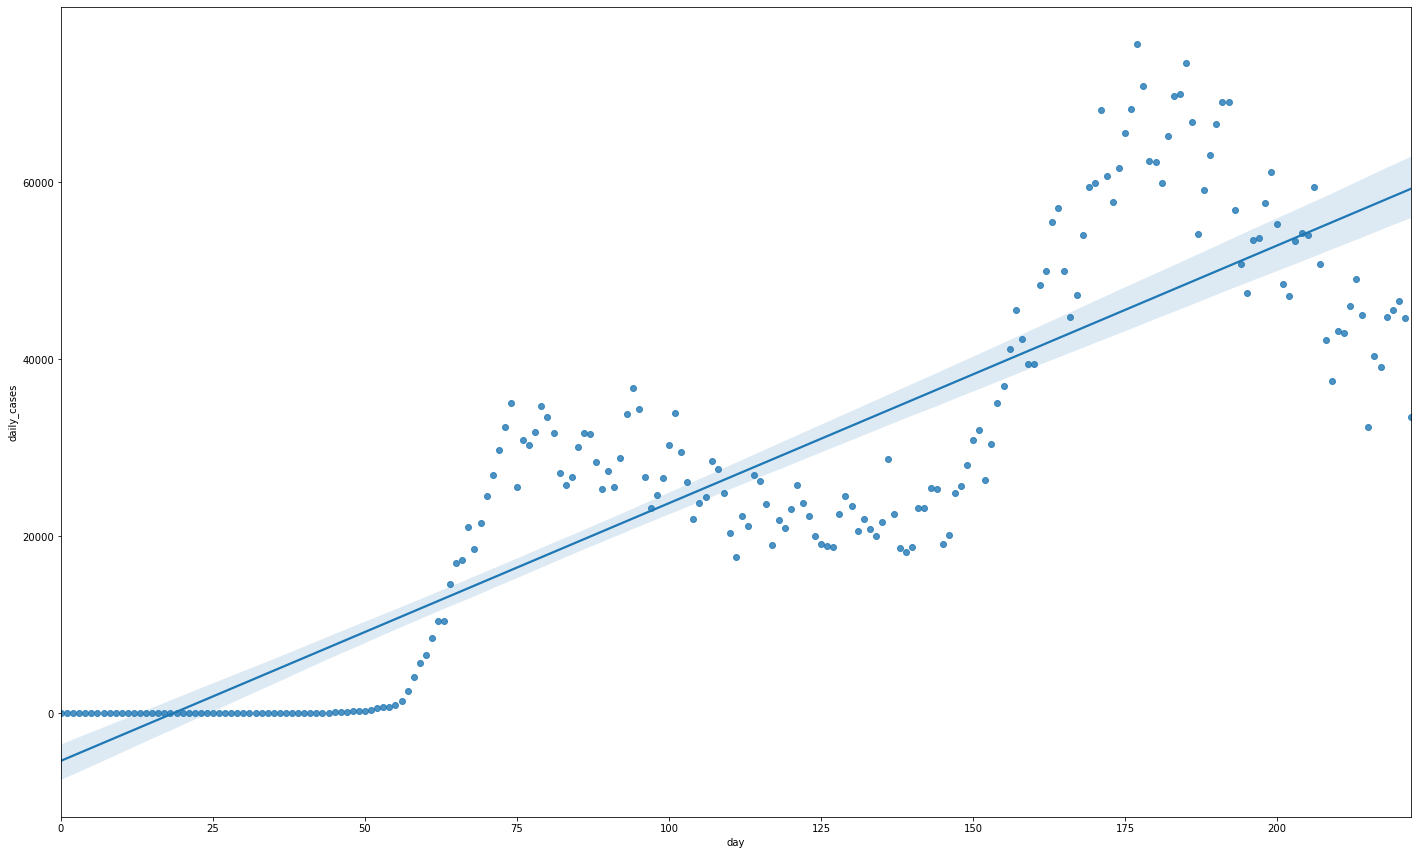

In [7]:
cases['day'] = list(range(len(cases)))

fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
sns.regplot(x='day', y='daily_cases', data=cases, ax=ax)
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
import math

def get_angle(p1, p2):
    xx = p2[0] - p1[0]
    yy = p2[1] - p1[1]
    return math.degrees(math.atan2(yy, xx))

def get_linear_regression_for_state(df, field='daily_cases', days=30):
    X = df['day'].values.reshape(-1, 1)[len(df['day'])-days:]
    Y = df[field].values.reshape(-1, 1)[len(df[field])-days:]
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y = linear_regressor.predict(X)
    return get_angle(
        (0,y[0]),
        (len(X)-1, y[-1])
    )

def state_is_trending_up(state, angle_floor=25, seven_day_case_floor=200):
    state_df = states[states.state==state]
    if state_df['seven_day_case'].values[-1] < seven_day_case_floor:
        return False
    else:
        return get_linear_regression_for_state(state_df) > angle_floor


state_names = list(states['state'].unique())
upward_trending_states = [s for s in state_names if state_is_trending_up(s)]
print(f'{len(upward_trending_states)} states with a regression angle > 25 in the last 30 days')
upward_trending_states

13 states with a regression angle > 25 in the last 30 days


['Illinois',
 'Nebraska',
 'North Carolina',
 'Hawaii',
 'Indiana',
 'Kentucky',
 'Minnesota',
 'Kansas',
 'Missouri',
 'Iowa',
 'Michigan',
 'South Dakota',
 'North Dakota']

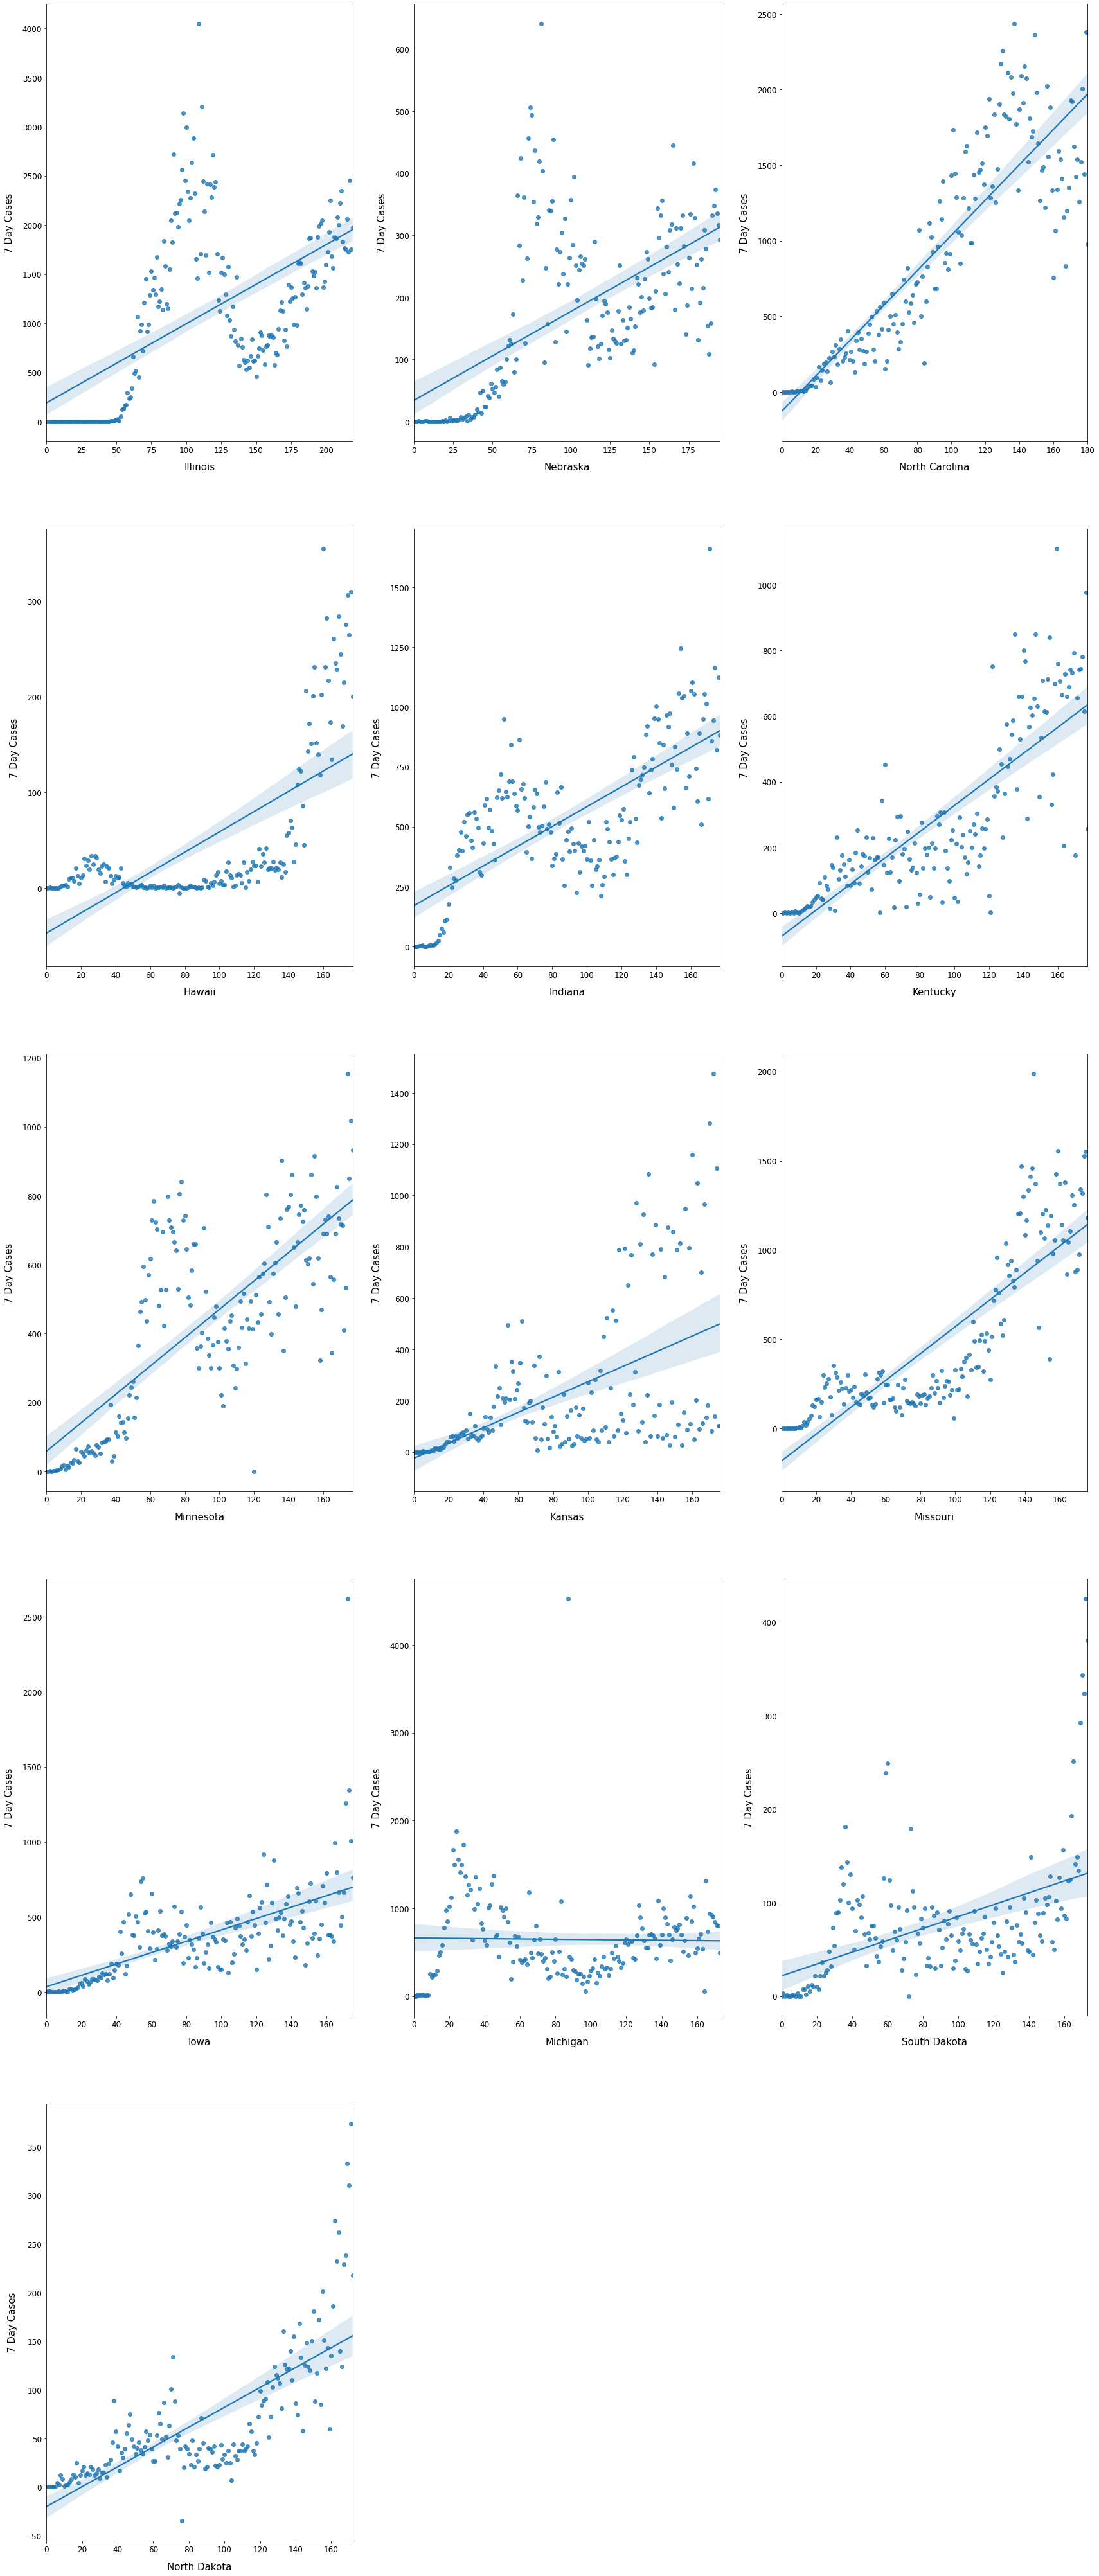

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, sname in enumerate(upward_trending_states, 1):
    plt.subplot(20, 3, i)
    sns.regplot(x='day', y='daily_cases', data=states[states.state == sname])
    
    plt.xlabel('{}'.format(sname), size=15,labelpad=12.5)
    plt.ylabel('7 Day Cases', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
        
plt.show()

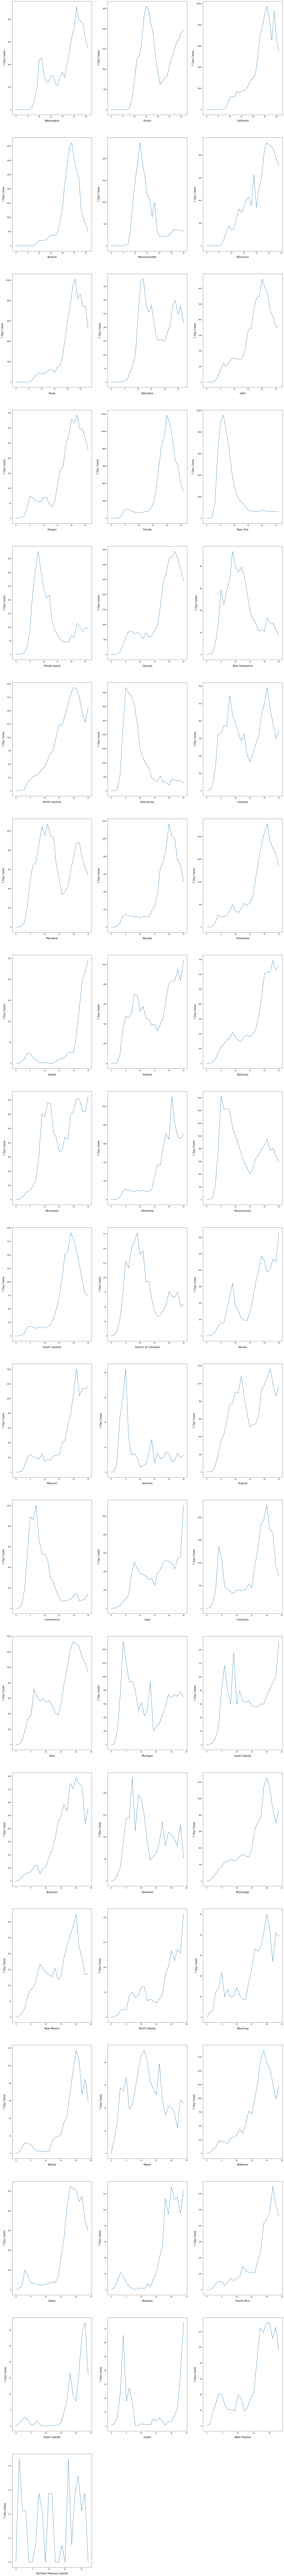

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
state_names = list(states['state'].unique())
for i, sname in enumerate(state_names, 1):
    plt.subplot(20, 3, i)
    d = states[states.state == sname]
    a = list(d['seven_day_case'])
    wc = [a[i] for i in range(0, len(a), 7)]
    plt.plot(wc)
    plt.xlabel('{}'.format(sname), size=15,labelpad=12.5)
    plt.ylabel('7 Day Cases', size=15, labelpad=12.5)
    
        
plt.show()